In [1]:
from tree.tree import *
nodes = []
state_dim = 3
obs_dim = 3
action_dim = 3
n = 100
for i in range(n):
    nodes.append(stateNode(str(i), state_dim, obs_dim, action_dim))

In [3]:
from tree.tree import GST
from agent.agent import debugAgent
from env.propagator import debugPropagator
gst = GST(10, 10, 6, 6, 3)
A = debugAgent()
P = debugPropagator()

In [3]:
from tree.tree import stateDict
sd = stateDict(6, 6, 3)
gst.reset(sd)

In [5]:
gst.step(A, P)

False

In [6]:
import anytree
for pre, _, node in anytree.RenderTree(gst.root):
    print("%s%s" % (pre, node.name))


root
├── gen0_node0
├── gen0_node1
│   └── gen1_node1
├── gen0_node2
├── gen0_node3
├── gen0_node4
│   ├── gen1_node0
│   └── gen1_node5
├── gen0_node5
│   ├── gen1_node4
│   └── gen1_node6
├── gen0_node6
│   ├── gen1_node3
│   └── gen1_node7
├── gen0_node7
│   └── gen1_node9
├── gen0_node8
│   └── gen1_node2
└── gen0_node9
    └── gen1_node8


In [1]:
from env.env import debugEnv
E = debugEnv(10, 200)
from agent.agent import debugAgent
A = debugAgent()

In [2]:
E.reset()
dicts = E.simulate(A)

In [ ]:
dicts[0]

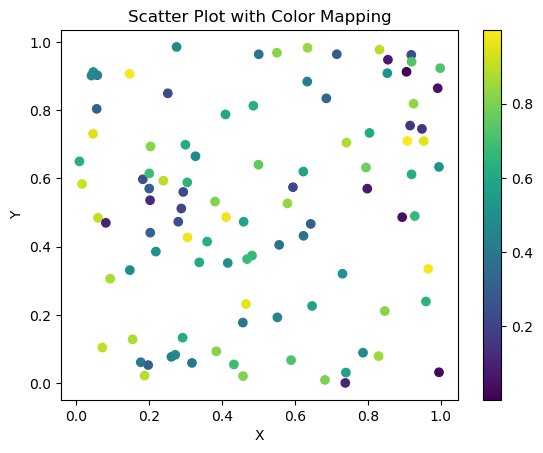

In [8]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.rand(100)
y = np.random.rand(100)
t = np.random.rand(100)  # Third variable (e.g., magnitude)

plt.scatter(x, y, c=t, cmap='viridis')
plt.colorbar()

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter Plot with Color Mapping")
plt.show()